### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

%matplotlib inline

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
## Open data files

---
---
#### Open our merged GOES-CUES dataset

In [3]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

Set font sizes for plots

In [4]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Make a quick plot

Make sure we're looking at the right information

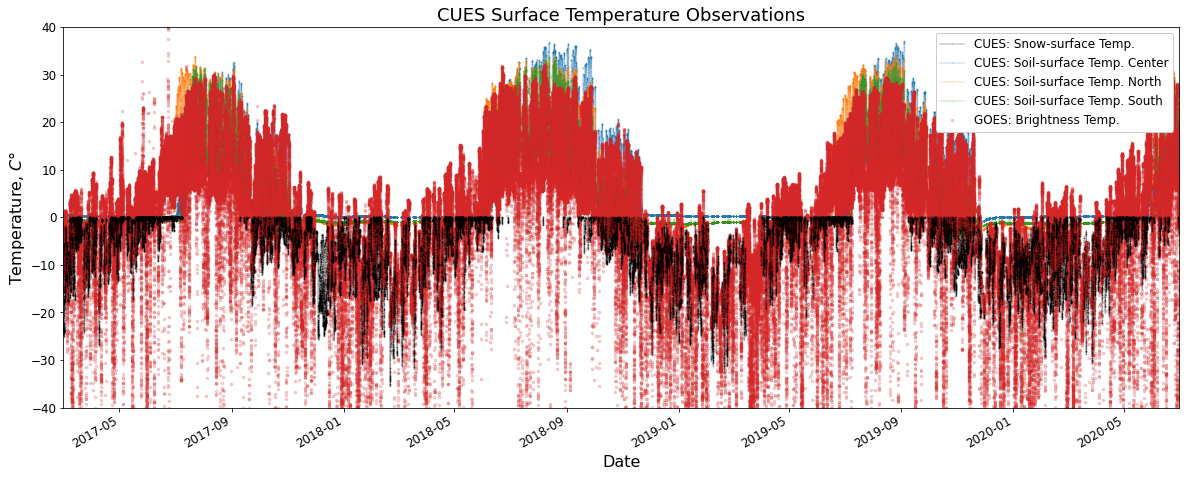

In [7]:
# Set start and end dates for time period we want to look at
startdate = cues_ds.datetime.min().values
enddate = cues_ds.datetime.max().values
#startdate = pd.Timestamp('2017-03-20')
#enddate = pd.Timestamp('2017-03-21')

alpha = 0.2
condition = cues_ds.cloud_flag==0

# Set up figure
fig, ax = plt.subplots(figsize=(20,7))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)

# Plot CUES soil surface temperature
cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)

# Plot GOES brightness temperature
cues_ds.goes_tb_c.where(condition).plot(c='tab:red', linestyle='none', marker='.', markersize=5, ax=ax, alpha=alpha)



ax.set_xlim([startdate,enddate])
ax.set_ylim([-40,40])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Date')

# Make legend
lines = [ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3], ax.lines[4]]
labels = ['CUES: Snow-surface Temp.', 
          'CUES: Soil-surface Temp. Center', 
          'CUES: Soil-surface Temp. North', 
          'CUES: Soil-surface Temp. South',
          'GOES: Brightness Temp.']
ax.legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)

# Set title
plt.title('CUES Surface Temperature Observations');

# Save figure image
#plt.savefig('goes-cues-Mar2017-Dec2019.jpg',dip=300);

---

#### Plots and analysis

It looks like "no snow" is anywhere below 5 cm of snow depth.

And I think soil temperatures <= 1 C are typically burried in snow, so I will use a threshold to ignore those values for now.

In [8]:
snow_depth_treshold = 5 # cm

soil_t_threshold = 1 # deg C

Compute mean soil temps

In [9]:
soil_temps = cues_ds[['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)',
'soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)',
'soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)']]

cues_ds['mean_soil_temp'] = xr.DataArray( soil_temps.to_dataframe().mean(axis=1) )

Compute daily median snow depth

In [10]:
# resample to daily and compute median
cues_ds['daily_median_snow_depth'] = cues_ds['snow depth  remote boom;  ultrasonic depth pinger on remote boom; (cm)'].resample(datetime="1D").median()
# fill nan values by day
cues_ds['daily_median_snow_depth'] = cues_ds['daily_median_snow_depth'].to_dataframe().loc[cues_ds.to_dataframe().index].fillna(method='bfill')
# set snow depth to 0 when our soil is too warm
cues_ds['daily_median_snow_depth'][cues_ds.mean_soil_temp>soil_t_threshold] = 0
# squeeze to remove extra dim that gets created in here
cues_ds['daily_median_snow_depth'] = cues_ds.daily_median_snow_depth.squeeze()

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


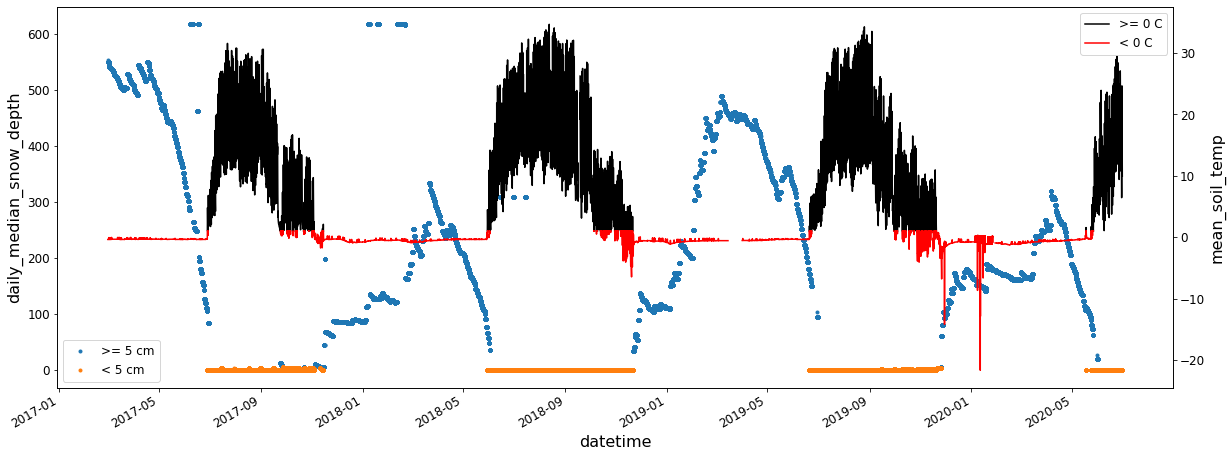

In [11]:
fig, ax = plt.subplots(figsize=(20,7))


cues_ds.daily_median_snow_depth.where(cues_ds.daily_median_snow_depth>=snow_depth_treshold).plot(linestyle='none',marker='.',ax=ax, label='>= 5 cm')
cues_ds.daily_median_snow_depth.where(cues_ds.daily_median_snow_depth<snow_depth_treshold).plot(linestyle='none',marker='.',ax=ax, label='< 5 cm')

plt.legend(loc='lower left')

ax2 = ax.twinx()

cues_ds.mean_soil_temp.where(cues_ds.mean_soil_temp>soil_t_threshold).plot(ax=ax2, color='k', label='>= 0 C')
cues_ds.mean_soil_temp.where(cues_ds.mean_soil_temp<=soil_t_threshold).plot(ax=ax2, color='r', label='< 0 C')
#.where(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold).plot(ax=ax2)



plt.legend(loc='upper right')

From the plot above it looks like using snow depth is the better way to determine if we want snow or soil temperature.

Create a new "surface temperature" that's snow OR soil:

In [12]:
snow_depth_treshold = 5 # cm

# Create the surface temperature field with the snow surface temperature value everywhere
cues_ds['surface_temperature'] = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].copy()
# Wherever snow depth is below the threshold, set surface temperature field to mean soil temperature
cues_ds['surface_temperature'][cues_ds.daily_median_snow_depth<snow_depth_treshold] = cues_ds.mean_soil_temp[cues_ds.daily_median_snow_depth<snow_depth_treshold]

#cues['surface_temperature_source'] = [ "snow" if depth >= snow_depth_treshold else "soil" for depth in cues_ds.daily_median_snow_depth]

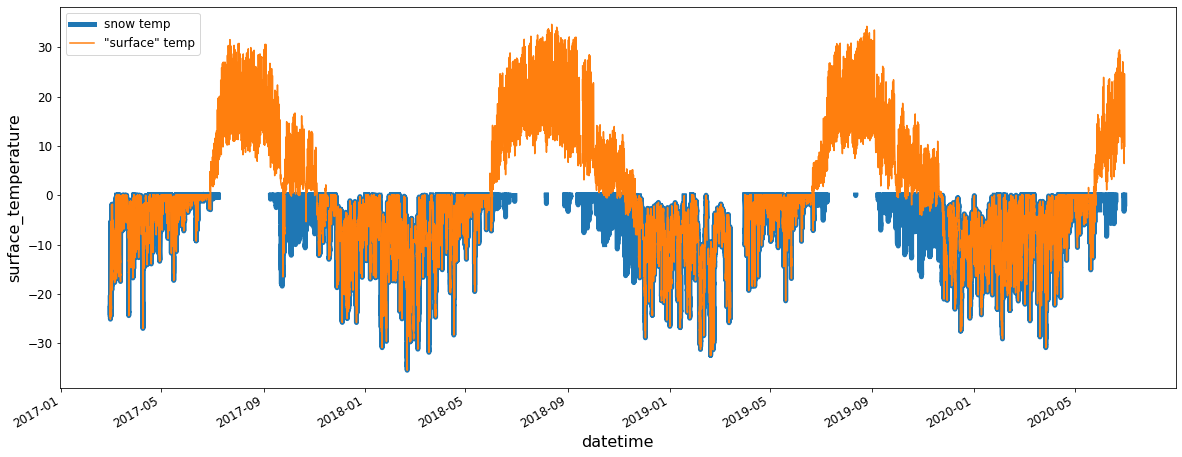

In [13]:
fig, ax = plt.subplots(figsize=(20,7))

cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(ax=ax, label='snow temp', linewidth='5')
cues_ds.surface_temperature.plot(ax=ax, label='"surface" temp')

plt.legend()

I don't know if I like this "surface temperature" field too much. I'll probably want to change it.

Text(0.5, 1.0, 'GOES-16 ABI Band 14 ($11.2 \\mu m$)\nand CUES Ground-based Observations')

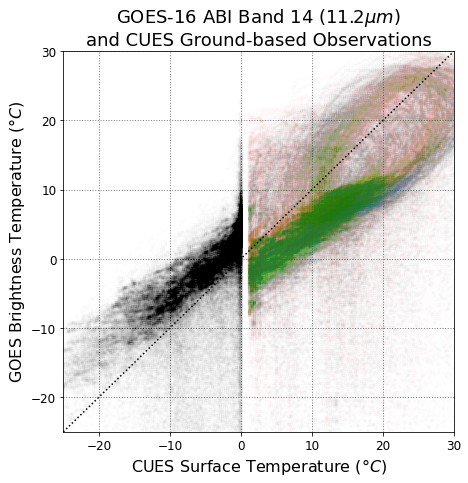

In [15]:
plt.figure(figsize=(7,7))
# gridlines
plt.grid(color='grey', linestyle=':', linewidth=1)


# GOES Tb vs Surface Temp
plt.plot(cues_ds.surface_temperature.where(cues_ds.cloud_flag==0),
         cues_ds.goes_tb_c.where(cues_ds.cloud_flag==0),
         '.k',alpha=0.001)


# GOES Tb vs snow temp
plt.plot(cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cues_ds.cloud_flag==0),
         cues_ds.goes_tb_c.where(cues_ds.cloud_flag==0),
         '.k',alpha=0.005)

# GOES Tb vs soil temp
plt.plot(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold),
         cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) &(cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'] > soil_t_threshold)),
         '.',alpha=0.005)
plt.plot(cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold),
         cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'] > soil_t_threshold)),
         '.',alpha=0.005)
plt.plot(cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold),
         cues_ds.goes_tb_c.where((cues_ds.cloud_flag==0) & (cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'] > soil_t_threshold)),
         '.',alpha=0.005)

plt.ylabel('GOES Brightness Temperature ($\degree C$)')
plt.xlabel('CUES Surface Temperature ($\degree C$)')
plt.xlim([-25,30])
plt.ylim([-25,30])

# 1-to-1 line for reference
plt.plot([-25,30],[-25,30],'k:')

# add legend
#plt.legend()

# zero lines for reference
#plt.plot([-25,20],[0,0],':',c='lightgrey')
#plt.plot([0,0],[-25,20],':',c='lightgrey')

plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations')

### Export back to pickle

In [18]:
cues_ds.to_dataframe().to_pickle('data/goes-cues_2017-2020_.pkl')